In [7]:
import joblib
import json
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
from sentence_transformers import SentenceTransformer
from datetime import datetime
import sys
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from xgboost import XGBClassifier, XGBRegressor
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, r2_score, mean_squared_error
from sklearn.preprocessing import label_binarize

REFERENCE_DATE = datetime(1970, 1, 1)

def process_timestamp(timestamp):
   
    date_part = timestamp[:8]  
    time_part = timestamp[8:] 

    date_obj = datetime.strptime(date_part, "%Y%m%d")
    days_since_epoch = (date_obj - REFERENCE_DATE).days

    return days_since_epoch, int(time_part)

def replace_x_with_127(ip_address):
   
    if ip_address.endswith(".*"):
        return ip_address[:-2] + ".127"
    return ip_address

def ip_to_numeric(ip_address):
    """
    Convert an IP address (e.g., '192.168.1.1') to a 32-bit integer.
    If the IP address is invalid or missing, return a default value (e.g., 127).
    """
    try:
        
        ip_address = replace_x_with_127(ip_address)
        octets = list(map(int, ip_address.split(".")))
        numeric_ip = (octets[0] << 24) + (octets[1] << 16) + (octets[2] << 8) + octets[3]
        return numeric_ip
    except (IndexError, ValueError, AttributeError):
        return 127

profile_json_path = f"../profile.json"
with open(profile_json_path, "r", encoding="utf-8") as f:
    profile_embeddings = json.load(f)

advertiser_json_path = f"../avertiser_id.json"
with open(advertiser_json_path, "r", encoding="utf-8") as f:
    advertiser_embeddings = json.load(f)
    
INTERESTS = [
    "10006", "10024", "10031", "10048", "10052", "10057", "10059", "10063", "10067", "10074",
    "10075", "10076", "10077", "10079", "10083", "10093", "10102", "10684", "11092", "11278",
    "11379", "11423", "11512", "11576", "11632", "11680", "11724", "11944", "13042", "13403",
    "13496", "13678", "13776", "13800", "13866", "13874", "14273", "16593", "16617", "16661",
    "16706", "16751", "10110", "10111"
]

def get_interest_scores(profile_interests, advertiser_id):
    interest_vector = np.zeros(44)  
    advertiser_data = advertiser_embeddings.get(str(advertiser_id), {})
    advertiser_embedding = np.array(advertiser_data.get("embed", [0] * 512))
    n_value = float(advertiser_data.get("N", 0))
    for i, interest_id in enumerate(INTERESTS):
        if interest_id in profile_interests:
            profile_embedding = np.array(profile_embeddings.get(interest_id, {}).get("embed", [0] * 512))
            similarity = cosine_similarity([advertiser_embedding], [profile_embedding])[0][0]
            interest_vector[i] = similarity*n_value 
    return interest_vector

class RTBDataset_new(Dataset):
    def __init__(self, imp_file_path, clk_file_path, city_embeddings_path, region_embeddings_path):
        super().__init__()
        with open(city_embeddings_path, 'r') as f:
            self.city_embeddings_dict = json.load(f)

        with open(region_embeddings_path, 'r') as f:
            self.region_embeddings_dict = json.load(f)
        
        self.column_names = [
        "BidID", "Timestamp", "Logtype", "VisitorID", "User-Agent", "IP", "Region", "City",
        "Adexchange", "Domain", "URL", "AnonymousURLID", "AdslotID", "Adslotwidth",
        "Adslotheight", "Adslotvisibility", "Adslotformat", "Adslotfloorprice",
        "CreativeID", "Biddingprice", "Payingprice", "KeypageURL", "AdvertiserID", "User_tag"
        ]
        
        self.imp = pd.read_csv(imp_file_path, delimiter='\t',names=self.column_names ,low_memory=True)
        self.clk = pd.read_csv(clk_file_path, delimiter='\t',names=self.column_names ,low_memory=True)
        
        self.should_bid = self.imp['BidID'].isin(self.clk['BidID'])
        self.paying_price = self.imp['Payingprice']
        
        self.imp['IP_numeric'] = self.imp['IP'].apply(ip_to_numeric)
        min_value = self.imp['IP_numeric'].min()
        max_value = self.imp['IP_numeric'].max()
        self.imp['IP_numeric_normalized'] = (self.imp['IP_numeric'] - min_value) / (max_value - min_value)
        self.imp[['days_since_epoch', 'time_part']] = self.imp['Timestamp'].apply(
            lambda x: pd.Series(process_timestamp(str(x)))
        )
        
    def __len__(self):
        return len(self.imp)

    def __getitem__(self, idx):
        row = self.imp.iloc[idx]
        should_bid = float(self.should_bid.iloc[idx])
        paying_price = float(self.paying_price.iloc[idx]) if not pd.isna(self.paying_price.iloc[idx]) else 0.0
        advertiser_id = row['AdvertiserID']
        profile_interests = row['User_tag']
        if not pd.isna(profile_interests):
            interest_scores = get_interest_scores(profile_interests, advertiser_id)
        else:
            interest_scores=torch.zeros(44)
            
        city_embedding = self.city_embeddings_dict.get(str(row['City']), self.city_embeddings_dict["0"])
        region_embedding = self.region_embeddings_dict.get(str(row['Region']), self.region_embeddings_dict["0"])
        ad_features = np.array([
            int(row['Adslotwidth']), int(row['Adslotheight']),
            int(row['Adslotvisibility']), int(row['Adslotformat']),
            float(row['Adslotfloorprice']),row['days_since_epoch'], row['time_part'], row['IP_numeric_normalized']
        ])
  
       
        features = np.concatenate([
            ad_features,
            city_embedding,
            region_embedding,
            interest_scores
        ])
        return features , should_bid, paying_price

In [8]:

imp_file = "../../../../ignore/Adobe Devcraft Dataset/dataset/imp.12.txt"
clk_file = "../../../../ignore/Adobe Devcraft Dataset/dataset/clk.12.txt"
city_file = r"city_embeddings.json"
region_file = r"region_embeddings.json"

print('intialising dataset.....')
dataset = RTBDataset_new(imp_file, clk_file, city_file, region_file)
dataloader = DataLoader(dataset, batch_size=512, shuffle=True)
print('initalisation complete!')

all_features = []
all_should_bid = []
all_paying_price = []

for batch in tqdm(dataloader):
    # print("in loop")
    features, should_bid, paying_price = batch
    all_features.append(features)
    all_should_bid.append(should_bid)
    all_paying_price.append(paying_price)

X = np.vstack(all_features)
y_bid = np.hstack(all_should_bid)
y_price = np.hstack(all_paying_price)

# X_train, X_test, y_bid_train, y_bid_test, y_price_train, y_price_test = train_test_split(
#     X, y_bid, y_price, test_size=0.05, random_state=42
# )
# print(X.shape,y_price.shape,y_bid_train.shape)

# scale_pos_weight = (y_bid_train == 0).sum() / (y_bid_train == 1).sum()

xgb_params_bid = {
    "n_estimators": 100, 
    "max_depth": 6,       
    "learning_rate": 0.1,  
    "objective": "binary:logistic", 
    "eval_metric": "logloss",  
    "use_label_encoder": False,
    "subsample": 0.8,    
    "colsample_bytree": 0.8, 
    "reg_alpha": 0.1,    
    "reg_lambda": 0.1,    
    "seed": 42,
    # "scale_pos_weight": scale_pos_weight           
}

quantile_alpha = 0.1

xgb_params_price = {
    "n_estimators": 100,  
    "max_depth": 6,      
    "learning_rate": 0.1, 
    "objective": "reg:quantileerror",  
    "quantile_alpha": quantile_alpha, 
    "eval_metric": "rmse", 
    "subsample": 0.8,    
    "colsample_bytree": 0.8, 
    "reg_alpha": 0.1,     
    "reg_lambda": 0.1,    
    "seed": 42            
}


intialising dataset.....
initalisation complete!


100%|██████████| 3237/3237 [30:53<00:00,  1.75it/s]


Accuracy: 0.6626
Precision: 0.9990
Recall: 0.6626
F1 Score: 0.7963
ROC AUC Score: 0.8350


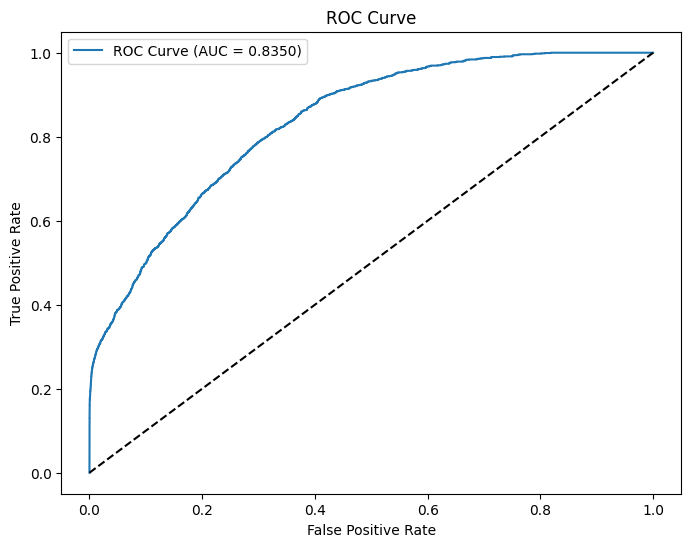

In [9]:
# Load the model
model_bid = joblib.load("xgb_bid_model.joblib")

# Predict the labels
y_bid_pred = model_bid.predict(X)

# Compute Accuracy
accuracy = accuracy_score(y_bid, y_bid_pred)
print(f"Accuracy: {accuracy:.4f}")

# Compute Precision
precision = precision_score(y_bid, y_bid_pred, average='weighted')  # Use 'binary' for binary classification
print(f"Precision: {precision:.4f}")

# Compute Recall
recall = recall_score(y_bid, y_bid_pred, average='weighted')
print(f"Recall: {recall:.4f}")

# Compute F1-score
f1 = f1_score(y_bid, y_bid_pred, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Compute ROC-AUC Score (Only for binary or multilabel classification)
if len(np.unique(y_bid)) == 2:
    roc_auc = roc_auc_score(y_bid, model_bid.predict_proba(X)[:, 1])  # Probability for the positive class
    print(f"ROC AUC Score: {roc_auc:.4f}")

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_bid, model_bid.predict_proba(X)[:, 1])
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.4f})")
    plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line for reference
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

In [10]:
from sklearn.metrics import  confusion_matrix
import seaborn as sns
matrix=confusion_matrix(y_bid, y_bid_pred)
print(matrix)
plt.figure(figsize=(8, 6))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])

plt.title('Confusion Matrix Heatmap')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.savefig('confusion_matrix.png')
plt.close()

[[1097055  558914]
 [    246    1123]]


In [11]:
model_price = joblib.load("xgb_price_model.joblib")

y_pred_price = model_price.predict(X)

# Compute Mean Squared Error (MSE)
mse = mean_squared_error(y_true=y_price, y_pred=y_pred_price)
print(f"Mean Squared Error (MSE): {mse:.4f}")

# Compute R-squared (R2) score
r2 = r2_score(y_true=y_price, y_pred=y_pred_price)
print(f"R2 Score: {r2:.4f}")

Mean Squared Error (MSE): 3469.6974
R2 Score: -0.0472
